# NeuroMANCER parameter estimation of ODE system

Parameter estimation for a 1D [Brusselator system](https://en.wikipedia.org/wiki/Brusselator).


## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [31]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import argparse
from torch.utils.data import DataLoader
import os

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.dynamics.ode import ODESystem
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.psl import plot
from neuromancer import psl

torch.manual_seed(0)

## Generate trajectories from ODE system to model

Consider the Brusselator system defined by the ordinary differential equations: 

$$
 \frac{dx_1}{dt} = \alpha + x_2 x_1^2 -\beta x_1 -x_1  \\  
 \frac{dx_2}{dt} = \beta x_1 - x_2 x_1^2
$$  

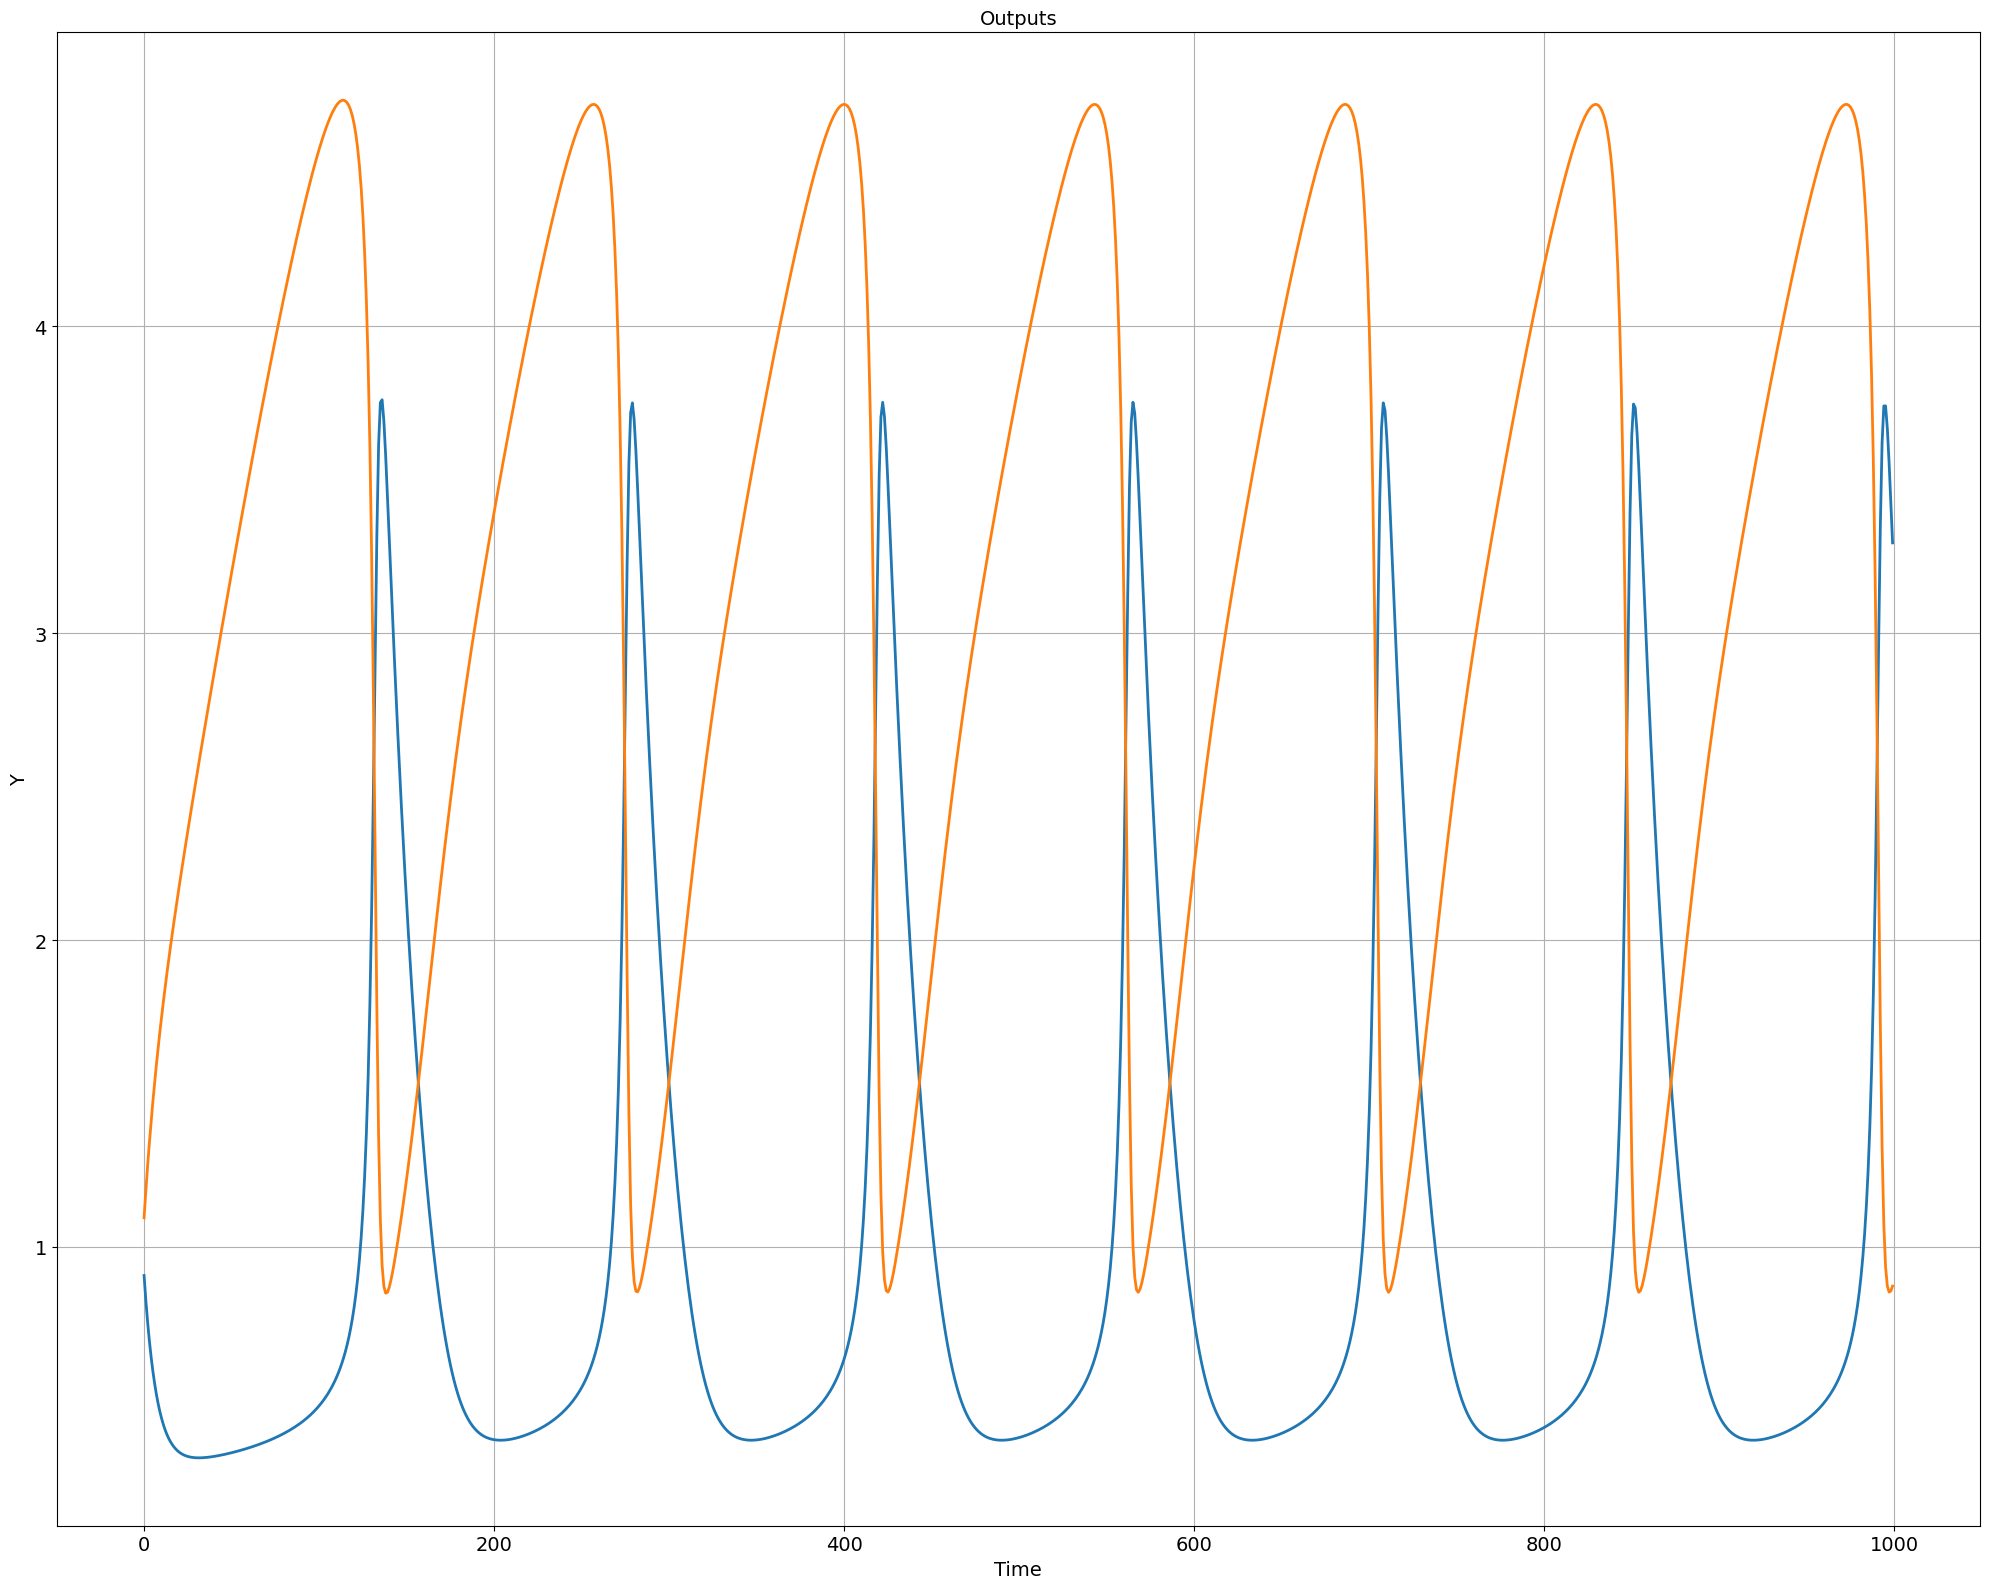

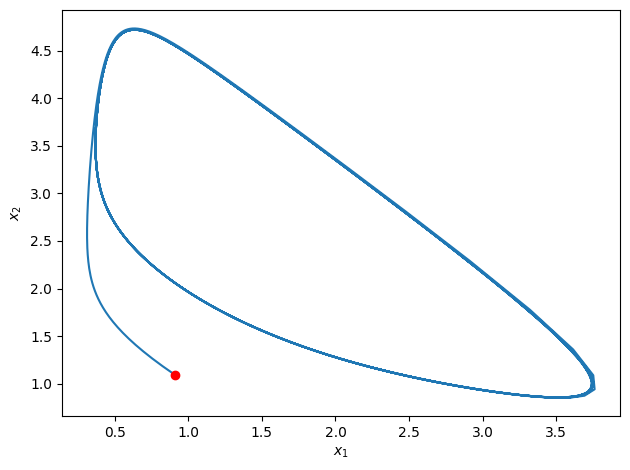

In [32]:
# %%  ground truth system
system = psl.systems['Brusselator1D']
ts = 0.05
modelSystem = system()
nx = modelSystem.nx
# simualte ground truth system
raw = modelSystem.simulate(nsim=1000, ts=ts)
# plot trajectories
plot.pltOL(Y=raw['Y'])
plot.pltPhase(X=raw['Y'])

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics to model: 
$$\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.


In [33]:
def get_data(sys, nsim, nsteps, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.ODE_NonAutonomous)
    :param normalize: (bool) Whether to normalize the data

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=0.05) for i in range(3)]
    nx = sys.nx
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :]}

    return train_loader, dev_loader, test_data

In [34]:
train_loader, dev_loader, test_data = get_data(modelSystem, 500, 2, 32)

## System model in Neuromancer

Here we construct an open-loop system composed of the system dynamics model  $x_{k+1} = \text{ODESolve}(f_{\theta}(x_k, u_k))$ with trainable parameters $\theta$.

In [35]:
# define ODE system in Neuromancer
class BrusselatorParam(ODESystem):
    def __init__(self, insize=2, outsize=2):
        super().__init__(insize=insize, outsize=outsize)
        self.alpha = nn.Parameter(torch.tensor([5.0]), requires_grad=True)
        self.beta = nn.Parameter(torch.tensor([5.0]), requires_grad=True)
    
    def ode_equations(self, x):
        x1 = x[:, [0]]
        x2 = x[:, [-1]]
        dx1 = self.alpha + x2*x1**2 - self.beta*x1 - x1
        dx2 = self.beta*x1 - x2*x1**2
        return torch.cat([dx1, dx2], dim=-1)

In [36]:
# instantiate ODE system
brussels = BrusselatorParam()
# use ODE solver to discretize the ODE with a given timestep h
fxRK4 = integrators.RK4(brussels, h=ts)
# create symbolic system model in Neuromancer
dynamics_model = System([Node(fxRK4, ['xn'], ['xn'])])

In [37]:
# visualize the system
# dynamics_model.show()

## Define system identification loss function

**Tracking loss:**  
$$\ell_x = Q_x||x^i_k - \hat{x}^i_k||_2^2$$ 
**Finite difference loss:**  
$$\ell_{dx} =  Q_{dx}||\Delta x^i_k - \Delta \hat{x}^i_k||_2^2$$
where $\Delta x^i_k = x^i_{k+1} + x^i_k$

In [38]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# define finite difference variables
xFD = (x[:, 1:, :] - x[:, :-1, :])
xhatFD = (xhat[:, 1:, :] - xhat[:, :-1, :])

# finite difference loss - i.e., fitting first derivatives
fd_loss = 2.0*((xFD == xhatFD)^2)
fd_loss.name = 'FD_loss'

# reference tracking loss
reference_loss = ((xhat == x)^2)
reference_loss.name = "ref_loss"

## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big(\sum_{k=1}^{N}  Q_x||x^i_k - \hat{x}^i_k||_2^2  +  \sum_{k=1}^{N-1}  Q_{dx}||\Delta x^i_k - \Delta \hat{x}^i_k||_2^2  \Big) \\
&\text{subject to}    && x^i_{k+1} =  \text{ODESolve}(f_{\theta}(x^i_k)) \\
\end{align}
$$  

In [39]:
# %%
objectives = [reference_loss, fd_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

In [40]:
# plot computational graph
# problem.show()

## Solve the problem

In [41]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.1)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=10,
    warmup=10,
    epochs=100,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss")

In [9]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0  train_loss: 0.0288230013102293
epoch: 1  train_loss: 0.017091521993279457
epoch: 2  train_loss: 0.009261596947908401
epoch: 3  train_loss: 0.004228680860251188
epoch: 4  train_loss: 0.0015729435253888369
epoch: 5  train_loss: 0.0003902610915247351
epoch: 6  train_loss: 5.262921695248224e-05
epoch: 7  train_loss: 5.848890396009665e-06
epoch: 8  train_loss: 2.2836271455162205e-05
epoch: 9  train_loss: 2.3258144210558385e-05
epoch: 10  train_loss: 1.2638778571272269e-05
epoch: 11  train_loss: 4.155470378464088e-06
epoch: 12  train_loss: 5.376450644689612e-07
epoch: 13  train_loss: 7.427908599311195e-08
epoch: 14  train_loss: 2.137195451723528e-07
epoch: 15  train_loss: 1.8988642125350452e-07
epoch: 16  train_loss: 7.968330351104669e-08
epoch: 17  train_loss: 1.4315766350136983e-08
epoch: 18  train_loss: 2.349537897572418e-09
epoch: 19  train_loss: 4.272514786407555e-09
epoch: 20  train_loss: 4.045462187463045e-09
epoch: 21  train_loss: 2.3972033247332547e-09
epoch: 22  train_los

<All keys matched successfully>

## Parameter estimation results

In [10]:
# trained parameters
print('alpha = '+str(brussels.alpha.item()))
print('beta = '+str(brussels.beta.item()))

alpha = 1.0000513792037964
beta = 2.999898672103882


In [11]:
# Test set results
test_outputs = dynamics_model(test_data)

pred_traj = test_outputs['xn'][:, :-1, :]
true_traj = test_data['X']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

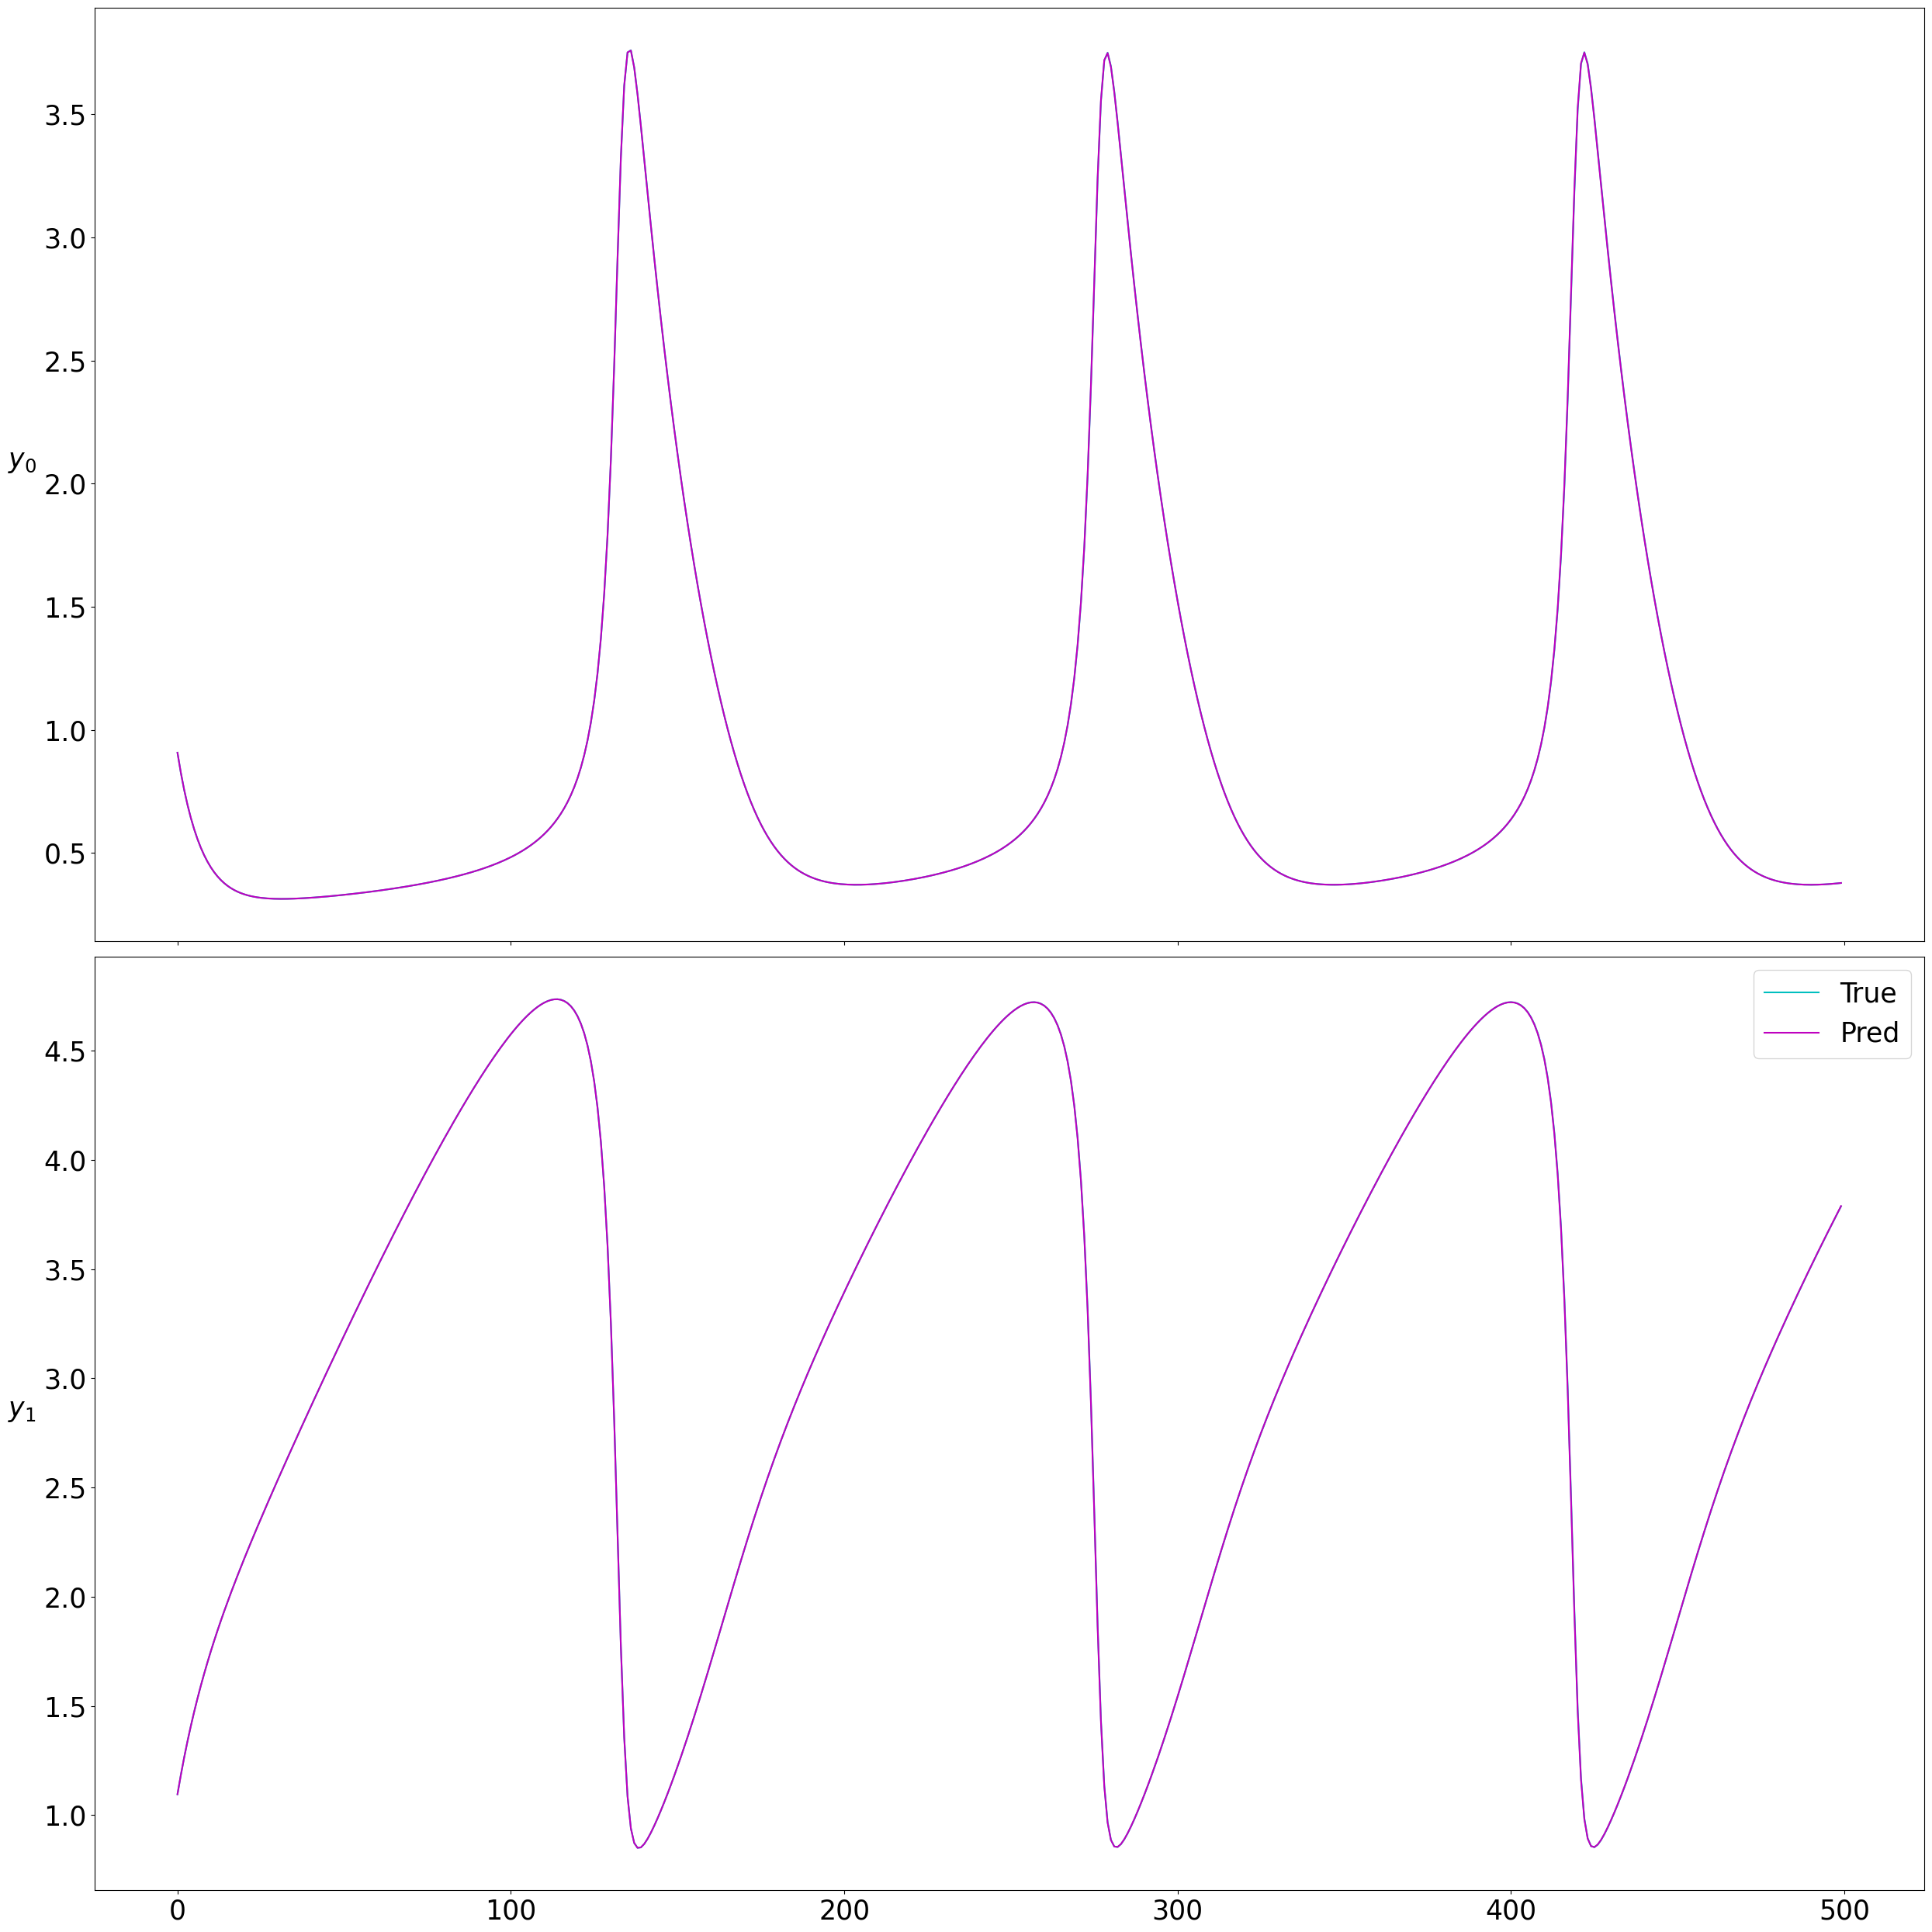

In [12]:
figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, label='True', c='c')
    axe.plot(t2, label='Pred', c='m')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
plt.tight_layout()
plt.savefig('open_loop.png')
